In [1]:
# cGAN for CIFAR-10
# This script contains the full, runnable code for a Conditional GAN.

import numpy as np
from numpy import expand_dims, ones, zeros
from numpy.random import randn, randint

import matplotlib.pyplot as plt

from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Embedding, Concatenate

In [2]:
''' 
This function defines the discriminator for a Conditional GAN (cGAN). Unlike a standard 
discriminator that only judges if an image is real or fake, a cGAN discriminator performs a more complex task: it determines if an image is a plausible example of its given class. 
It takes two inputs—an image and a class label—and outputs a single probability.

'''

' \nThis function defines the discriminator for a Conditional GAN (cGAN). Unlike a standard \ndiscriminator that only judges if an image is real or fake, a cGAN discriminator performs a more complex task: it determines if an image is a plausible example of its given class. \nIt takes two inputs—an image and a class label—and outputs a single probability.\n\n'

In [3]:


def define_discriminator(in_shape=(32, 32, 3), n_classes=10):
    """
    Defines the conditional GAN (cGAN) discriminator model.
    This model takes both an image and a class label as input.
    """

    # --- 1. Label Input Pathway ---
    # This path processes the conditional information (the class label).
    
    # Input layer for a single integer label (e.g., 0 for 'plane', 1 for 'car').
    in_label = Input(shape=(1,), name='Discriminator_Label_Input')
    
    # Embedding layer: Converts the integer label into a dense vector of a fixed size (50).
    # This creates a richer, learnable representation for each class.
    # Input dim: n_classes (10), Output dim: 50.
    li = Embedding(n_classes, 50)(in_label)
    
    # Upscale the embedded vector to the size of the image's spatial dimensions (32*32=1024).
    # This prepares the label information to be combined with the image.
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    
    # Reshape the label vector into a 1-channel feature map (32x32x1).
    # This allows it to be concatenated with the image channels.
    li = Reshape((in_shape[0], in_shape[1], 1))(li)

    # --- 2. Image Input Pathway ---
    # This path processes the image itself.
    
    # Input layer for the image data (e.g., 32x32x3 for CIFAR-10).
    in_image = Input(shape=in_shape, name='Discriminator_Image_Input')

    # --- 3. Concatenate Inputs ---
    # Merge the image and the prepared label feature map along the channel axis.
    # The image has 3 channels (RGB), and the label has 1 channel.
    # The result is a 4-channel tensor (32x32x4).
    merge = Concatenate()([in_image, li])

    # --- 4. CNN Feature Extractor ---
    # This is a standard convolutional network that downsamples the merged input
    # to extract features and classify the result.
    
    # Downsample from 32x32 to 16x16
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    
    # Downsample from 16x16 to 8x8
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    
    # --- 5. Classifier Head ---
    # Flatten the feature map into a single vector.
    fe = Flatten()(fe)
    # Apply dropout for regularization to prevent overfitting.
    fe = Dropout(0.4)(fe)
    
    # Output layer with a single neuron and sigmoid activation.
    # This outputs a single probability: P(image is real | class label).
    out_layer = Dense(1, activation='sigmoid')(fe)
    
    # --- 6. Define and Compile Model ---
    # Create the Keras Model, specifying its two inputs and one output.
    model = Model([in_image, in_label], out_layer, name="Conditional_Discriminator")
    
    # Use the Adam optimizer with parameters known to work well for GANs.
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    
    # Compile the model for binary classification.
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [4]:
'''
This function defines the generator model, which is the "artist" of the cGAN. Its job is to take a random noise vector and 
a specific class label (e.g., "car") and generate a new, synthetic image that matches that class.

 '''

'\nThis function defines the generator model, which is the "artist" of the cGAN. Its job is to take a random noise vector and \na specific class label (e.g., "car") and generate a new, synthetic image that matches that class.\n\n '

In [5]:


def define_generator(latent_dim, n_classes=10):
    """
    Defines the conditional GAN (cGAN) generator model.
    This model takes a latent vector (noise) and a class label as input.
    """

    # --- 1. Label Input Pathway ---
    # This path processes the conditional information (the class label).
    
    # Input layer for a single integer label.
    in_label = Input(shape=(1,), name='Generator_Label_Input')
    
    # Embedding layer: Converts the integer label into a dense 50-dimensional vector.
    # This creates a learnable, rich representation for each class.
    li = Embedding(n_classes, 50)(in_label)
    
    # Upscale the embedded vector to create a small foundation feature map (4x4).
    # This prepares the label information to be combined with the latent space info.
    n_nodes = 4 * 4
    li = Dense(n_nodes)(li)
    
    # Reshape the label vector into a 1-channel feature map (4x4x1).
    li = Reshape((4, 4, 1))(li)

    # --- 2. Latent Vector (Noise) Input Pathway ---
    # This path processes the random noise to create the image's core structure.
    
    # Input layer for the random noise vector.
    in_lat = Input(shape=(latent_dim,), name='Generator_Latent_Input')
    
    # Dense layer to project the latent vector into a high-dimensional space.
    # The number of nodes corresponds to a 4x4 image with 256 feature channels.
    n_nodes = 256 * 4 * 4
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # Reshape into a 256-channel feature map (4x4x256), the foundation of our image.
    gen = Reshape((4, 4, 256))(gen)

    # --- 3. Concatenate Inputs ---
    # Merge the two pathways. The label feature map (4x4x1) is concatenated
    # with the latent space feature map (4x4x256) to form a combined
    # feature map of 4x4x257. This injects the class condition into the image generation process.
    merge = Concatenate()([gen, li])

    # --- 4. Upsampling Blocks ---
    # A series of transposed convolutional layers that progressively increase the spatial
    # dimensions (upsample) while reducing the number of feature channels.
    
    # Upsample to 8x8
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # Upsample to 16x16
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # Upsample to 32x32
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # --- 5. Output Layer ---
    # A final Conv2D layer to produce the final image.
    # It has 3 channels for RGB color.
    # The 'tanh' activation is critical, as it scales the output pixel values
    # to the range [-1, 1], matching our preprocessed real images.
    out_layer = Conv2D(3, (3,3), activation='tanh', padding='same')(gen)

    # --- 6. Define Model ---
    # Create the Keras Model, specifying its two inputs and single output.
    # Note: The generator is not compiled here because it's trained as part of the combined GAN model.
    model = Model([in_lat, in_label], out_layer, name="Conditional_Generator")
    return model

In [6]:
'''
This function assembles the full Conditional GAN (cGAN) model by chaining the generator and discriminator together. Its sole purpose is to train the generator.

When this combined cGAN model is trained, the error signal flows backward from the discriminator's output, through its (frozen) layers, and only updates the generator's weights. 
This forces the generator to produce images that are better at fooling the discriminator for a given class label.
 '''

"\nThis function assembles the full Conditional GAN (cGAN) model by chaining the generator and discriminator together. Its sole purpose is to train the generator.\n\nWhen this combined cGAN model is trained, the error signal flows backward from the discriminator's output, through its (frozen) layers, and only updates the generator's weights. \nThis forces the generator to produce images that are better at fooling the discriminator for a given class label.\n "

In [7]:
# Import the necessary Keras model and optimizer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def define_gan(g_model, d_model):
    """
    Defines the combined cGAN model for training the generator.
    
    This function connects the generator and discriminator into a single, larger model.
    The key purpose is to create a pathway to train the generator's weights.
    """
    # --- 1. Freeze the Discriminator's Weights ---
    # This is the most critical step for training the generator. By setting the
    # discriminator's trainable property to False, we ensure that when we train
    # this combined model, only the generator's weights will be updated.
    d_model.trainable = False

    # --- 2. Connect the Generator and Discriminator ---
    # Get the two inputs from the generator model (latent noise and class label).
    # These will also serve as the inputs for our combined GAN model.
    gen_noise, gen_label = g_model.input
    
    # Get the single output from the generator (the generated image).
    gen_output = g_model.output

    # Connect the generator's output and the original label input to the discriminator.
    # The discriminator will then attempt to classify this generated image, given its label.
    gan_output = d_model([gen_output, gen_label])

    # --- 3. Define the Combined Model ---
    # Create the final GAN model.
    # It takes the same inputs as the generator (noise and label).
    # Its output is the discriminator's final decision.
    model = Model([gen_noise, gen_label], gan_output, name="cGAN")

    # --- 4. Compile the Model ---
    # Compile the combined model. The loss function here measures how well the
    # generator "fooled" the discriminator. The optimizer will use this loss
    # to update the generator's weights.
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model

In [8]:
# This function handles the initial loading and preprocessing of the entire dataset. For the cGAN, it's modified to 
# return both the images and their corresponding class labels.

def load_real_samples():
    """
    Loads the CIFAR-10 dataset and prepares it for use.
    - Converts images to float32.
    - Normalizes pixel values to the [-1, 1] range.
    - Returns both images and their corresponding integer labels.
    """
    # Load dataset from Keras
    (trainX, trainy), (_, _) = load_data()
    
    # Convert images to floating-point numbers
    X = trainX.astype('float32')
    
    # Normalize pixel values from [0, 255] to [-1, 1]
    X = (X - 127.5) / 127.5
    
    # Return images and their labels as a list
    return [X, trainy]


# This function creates a batch of real data to train the 
# discriminator. It randomly selects images and their true labels from the dataset.

def generate_real_samples(dataset, n_samples):
    """
    Selects a random batch of real images and their labels from the dataset.
    """
    # Unpack the dataset into images and labels
    images, labels = dataset
    
    # Choose a random set of indices
    ix = randint(0, images.shape[0], n_samples)
    
    # Select the images and labels for the batch
    X, batch_labels = images[ix], labels[ix]
    
    # Create the "real" target labels (vector of 1s) for the discriminator
    y = ones((n_samples, 1))
    
    return [X, batch_labels], y

# This function generates the inputs required by the generator: a batch of random noise vectors 
# and a corresponding batch of random class labels.

def generate_latent_points(latent_dim, n_samples, n_classes=10):
    """
    Generates the two inputs for the cGAN generator:
    1. A batch of random points from the latent space (noise).
    2. A batch of random integer class labels.
    """
    # Generate points in the latent space from a standard normal distribution
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    
    # Generate a batch of random integer labels (from 0 to n_classes-1)
    labels = randint(0, n_classes, n_samples)
    
    return [z_input, labels]

# This function creates a batch of fake data to train the discriminator. It uses the generator 
# to create images based on random noise and random labels.

def generate_fake_samples(generator, latent_dim, n_samples):
    """
    Uses the generator to create a batch of fake images.
    """
    # Generate the generator inputs (noise and random labels)
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    
    # Use the generator to predict images based on the inputs
    images = generator.predict([z_input, labels_input], verbose=0)
    
    # Create the "fake" target labels (vector of 0s) for the discriminator
    y = zeros((n_samples, 1))
    
    return [images, labels_input], y

# This function is for evaluating the generator's progress. It's a key part of the cGAN, as
#  it deliberately asks the generator to create images of each class and plots them in a grid
#  for visual inspection.

def summarize_performance(epoch, g_model, latent_dim, n_samples=100):
    """
    Evaluates generator performance by creating and displaying a plot of 
    generated images for each class directly in the output.
    """
    # Generate latent points to create 100 images
    latent_points, _ = generate_latent_points(latent_dim, n_samples)
    
    # Create a specific list of labels: 10 of class 0, 10 of class 1, etc.
    # This allows us to command the generator to create examples of each class.
    labels = np.asarray([x for _ in range(10) for x in range(10)])

    # Generate the images using the controlled labels
    X  = g_model.predict([latent_points, labels], verbose=0)
    
    # Denormalize the images from [-1, 1] to [0, 1] for plotting
    X = (X + 1) / 2.0

    # --- Plot the results ---
    plt.figure(figsize=(10, 10))
    # Add a title to the entire figure for context
    plt.suptitle(f'Generated Images at Epoch {epoch + 1}', fontsize=16)
    
    for i in range(100):
        plt.subplot(10, 10, 1 + i)
        plt.axis('off')
        plt.imshow(X[i, :, :])

    # Display the plot directly in the notebook output
    plt.show()
    


In [9]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
    """
    Main training loop for the Conditional GAN.
    """
    # Calculate how many batches are in one epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    # Loop over all epochs
    for i in range(n_epochs):
        # Loop over all batches in the epoch
        for j in range(bat_per_epo):
            # -----------------------------------
            # Step 1: Train the Discriminator
            # -----------------------------------
            
            # Get a half-batch of real images and their true labels
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # Train the discriminator on this real data
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)

            # Get a half-batch of fake images and their (randomly generated) labels
            [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # Train the discriminator on this fake data
            d_loss2, _ = d_model.train_on_batch([X_fake, labels_fake], y_fake)

            # -----------------------------------
            # Step 2: Train the Generator
            # -----------------------------------
            
            # Generate inputs for the generator: latent noise and random labels
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            
            # Create "inverted" labels (all 1s). We do this because we want to train
            # the generator to produce images that the discriminator will classify as "real".
            y_gan = ones((n_batch, 1))
            
            # Train the generator via the combined GAN model (discriminator weights are frozen)
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)

            # --- Summarize progress periodically ---
            if (j + 1) % 100 == 0:
                print(f'> Epoch {i+1}/{n_epochs}, Batch {j+1}/{bat_per_epo}, d1={d_loss1:.3f}, d2={d_loss2:.3f} g={g_loss:.3f}')

        # --- Evaluate and save model checkpoint periodically ---
        if (i + 1) % 10 == 0:
            # Create a plot of generated images for visual inspection
            summarize_performance(i, g_model, latent_dim)
            # Save the generator model
            filename = f'cgan_generator_model_{i + 1:03d}.h5'
            g_model.save(filename)
            print(f'> Saved model checkpoint: {filename}')

d:\Program Files\Python313\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


--- Starting cGAN Training ---


d:\Program Files\Python313\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


> Epoch 1/300, Batch 100/390, d1=1.335, d2=1.341 g=0.192
> Epoch 1/300, Batch 200/390, d1=1.540, d2=1.544 g=0.127
> Epoch 1/300, Batch 300/390, d1=1.667, d2=1.670 g=0.099
> Epoch 2/300, Batch 100/390, d1=1.811, d2=1.812 g=0.074
> Epoch 2/300, Batch 200/390, d1=1.857, d2=1.858 g=0.067
> Epoch 2/300, Batch 300/390, d1=1.893, d2=1.894 g=0.061
> Epoch 3/300, Batch 100/390, d1=1.944, d2=1.944 g=0.054
> Epoch 3/300, Batch 200/390, d1=1.964, d2=1.965 g=0.051
> Epoch 3/300, Batch 300/390, d1=1.981, d2=1.982 g=0.049
> Epoch 4/300, Batch 100/390, d1=2.008, d2=2.008 g=0.046
> Epoch 4/300, Batch 200/390, d1=2.019, d2=2.020 g=0.044
> Epoch 4/300, Batch 300/390, d1=2.029, d2=2.030 g=0.043
> Epoch 5/300, Batch 100/390, d1=2.045, d2=2.046 g=0.041
> Epoch 5/300, Batch 200/390, d1=2.053, d2=2.053 g=0.040
> Epoch 5/300, Batch 300/390, d1=2.059, d2=2.060 g=0.039
> Epoch 6/300, Batch 100/390, d1=2.071, d2=2.071 g=0.038
> Epoch 6/300, Batch 200/390, d1=2.076, d2=2.077 g=0.037
> Epoch 6/300, Batch 300/390, d

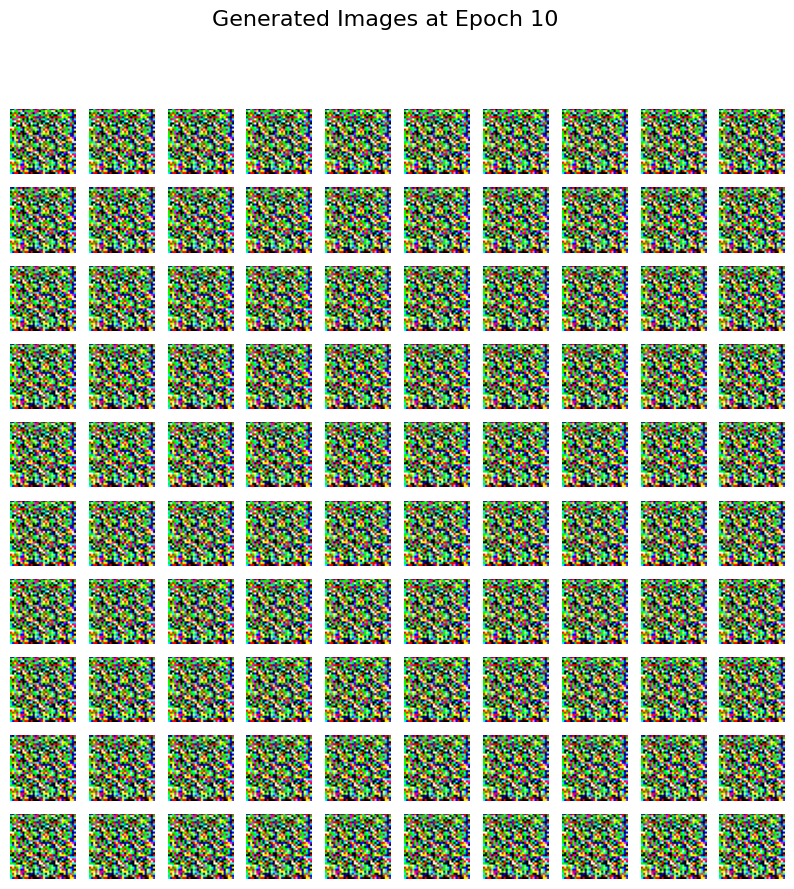

> Saved model checkpoint: cgan_generator_model_010.h5
> Epoch 11/300, Batch 100/390, d1=2.160, d2=2.161 g=0.030
> Epoch 11/300, Batch 200/390, d1=2.165, d2=2.165 g=0.030
> Epoch 11/300, Batch 300/390, d1=2.169, d2=2.169 g=0.030
> Epoch 12/300, Batch 100/390, d1=2.177, d2=2.177 g=0.029
> Epoch 12/300, Batch 200/390, d1=2.181, d2=2.181 g=0.029
> Epoch 12/300, Batch 300/390, d1=2.185, d2=2.186 g=0.029
> Epoch 13/300, Batch 100/390, d1=2.193, d2=2.193 g=0.028
> Epoch 13/300, Batch 200/390, d1=2.197, d2=2.197 g=0.028
> Epoch 13/300, Batch 300/390, d1=2.201, d2=2.202 g=0.028
> Epoch 14/300, Batch 100/390, d1=2.209, d2=2.209 g=0.027
> Epoch 14/300, Batch 200/390, d1=2.213, d2=2.213 g=0.027
> Epoch 14/300, Batch 300/390, d1=2.217, d2=2.217 g=0.027
> Epoch 15/300, Batch 100/390, d1=2.224, d2=2.225 g=0.026
> Epoch 15/300, Batch 200/390, d1=2.228, d2=2.229 g=0.026
> Epoch 15/300, Batch 300/390, d1=2.233, d2=2.233 g=0.026
> Epoch 16/300, Batch 100/390, d1=2.240, d2=2.240 g=0.026
> Epoch 16/300, Ba

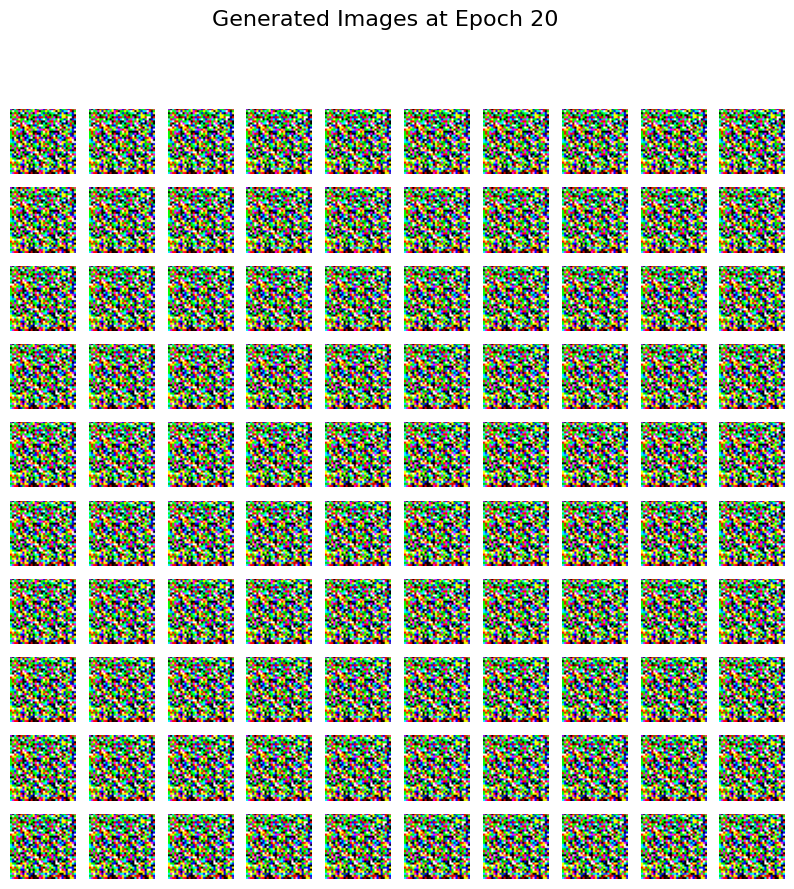

> Saved model checkpoint: cgan_generator_model_020.h5
> Epoch 21/300, Batch 100/390, d1=2.316, d2=2.316 g=0.022
> Epoch 21/300, Batch 200/390, d1=2.319, d2=2.319 g=0.022
> Epoch 21/300, Batch 300/390, d1=2.323, d2=2.323 g=0.022
> Epoch 22/300, Batch 100/390, d1=2.329, d2=2.330 g=0.022
> Epoch 22/300, Batch 200/390, d1=2.333, d2=2.333 g=0.022
> Epoch 22/300, Batch 300/390, d1=2.336, d2=2.336 g=0.021
> Epoch 23/300, Batch 100/390, d1=2.343, d2=2.343 g=0.021
> Epoch 23/300, Batch 200/390, d1=2.346, d2=2.347 g=0.021
> Epoch 23/300, Batch 300/390, d1=2.350, d2=2.350 g=0.021


KeyboardInterrupt: 

In [10]:
# --- 6. RUN THE TRAINING ---

# --- Define Hyperparameters ---
# The dimension of the random noise vector.
latent_dim = 100
# The number of full passes through the training dataset.
n_epochs = 300 # For good results, this should be higher (e.g., 200+)
# The number of samples processed in each batch.
n_batch = 128

# --- Create Models ---
# Instantiate the discriminator, generator, and combined GAN models.
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)

# --- Load Data ---
# Load and preprocess the CIFAR-10 images and labels.
dataset = load_real_samples()

# --- Start Training ---
# Call the main training function to begin the process.
print("--- Starting cGAN Training ---")
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs, n_batch)